In [73]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
#
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade

from tensorized_training import TTFC

In [74]:
tf.keras.backend.set_floatx("float64")

In [75]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

Text(0.5, 1.0, 'Data points (BCs & IC)')

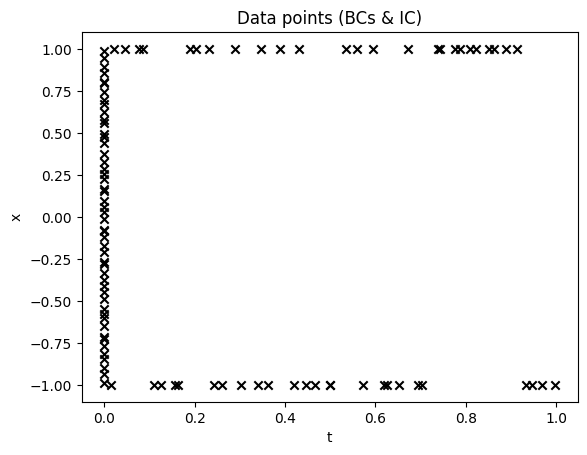

In [76]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="x", c="k")  
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [77]:
# output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

In [78]:
# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

In [79]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [80]:
### model design
#
neuron_per_layer = 20
#num_hidden_layers = 8
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

#ttfc = TTFC(neuron_per_layer, [3, 3], [42, 5, 2], "sigmoid") #tt rank random rn

# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
# hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
# hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
# hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
#hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
#hidden0 = ttfc(input_layer)
hidden1 = TTFC(neuron_per_layer, [3, 3], [42, 50, 2], "sigmoid")(hidden0)
hidden2 = TTFC(neuron_per_layer, [3, 3], [42, 50, 2], "sigmoid")(hidden1)
hidden3 = TTFC(neuron_per_layer, [3, 3], [42, 50, 2], "sigmoid")(hidden2)
hidden4 = TTFC(neuron_per_layer, [3, 3], [42, 50, 2], "sigmoid")(hidden3)
hidden5 = TTFC(neuron_per_layer, [3, 3], [42, 50, 2], "sigmoid")(hidden4)
hidden6 = TTFC(neuron_per_layer, [3, 3], [42, 50, 2], "sigmoid")(hidden5)
hidden7 = TTFC(neuron_per_layer, [3, 3], [42, 50, 2], "sigmoid")(hidden6)
#hidden8 = ttfc(hidden7)
# hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
# hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
# hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)
# hidden9 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden8)
# hidden10 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden9)
# hidden11 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden10)
# hidden12 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden11)
# hidden13 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden12)
# hidden14 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden13)



# hidden0 = tf.keras.layesr.Dense(neurons_per_layer, activation=actfn)(input_layer)
# for hidden in range(1, num_hidden_layers):
#     hidden = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_77 (Dense)            (None, 20)                60        
                                                                 
 ttfc_18 (TTFC)              (None, 20)                177       
                                                                 
 ttfc_19 (TTFC)              (None, 20)                177       
                                                                 
 ttfc_20 (TTFC)              (None, 20)                177       
                                                                 
 ttfc_21 (TTFC)              (None, 20)                177       
                                                                 
 ttfc_22 (TTFC)              (None, 20)                177 

In [81]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

In [82]:
# the physics informed loss function
# IMPORTANT: this loss function is used for collocation points
@tf.function
def f(t, x):
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    F = u_t + u0*u_x - (0.01/np.pi)*u_xx
    return tf.reduce_mean(tf.square(F))

In [83]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

In [84]:
import time

In [85]:
"""
BENCHMARK on Local Machine

Nu = 25 + 25 + 50
Nf = 10000
hidden = 9x20

learning_rate = 5e-4
epochs = 2000
training time ~ 8m 50s
final loss = 0.009
"""

"""
Nu = 50 + 50 + 100
Nf = 20000
hidden = 12x40
epochs = 2000
"""

epochs = 2000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f(t_c, x_c)
        # MSE loss for data points
        L2 = mse(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"{epoch:4} {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

   0 0.255
  10 0.248
  20 0.249
  30 0.248
  40 0.248
  50 0.248
  60 0.248
  70 0.248
  80 0.247
  90 0.245
 100 0.235
 110 0.214


KeyboardInterrupt: 

Text(0.5, 0, 'epoch')

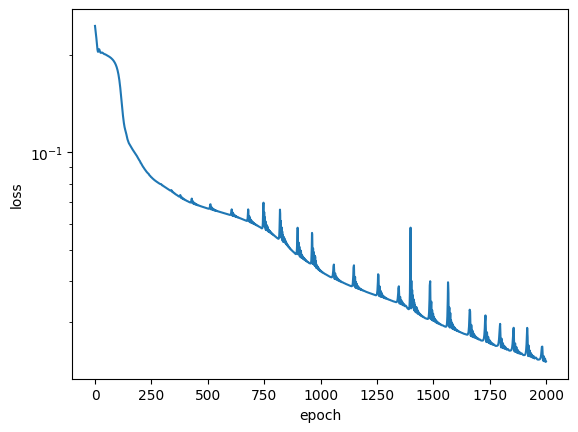

In [ ]:
plt.semilogy(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig("loss vs epoch 6x20")

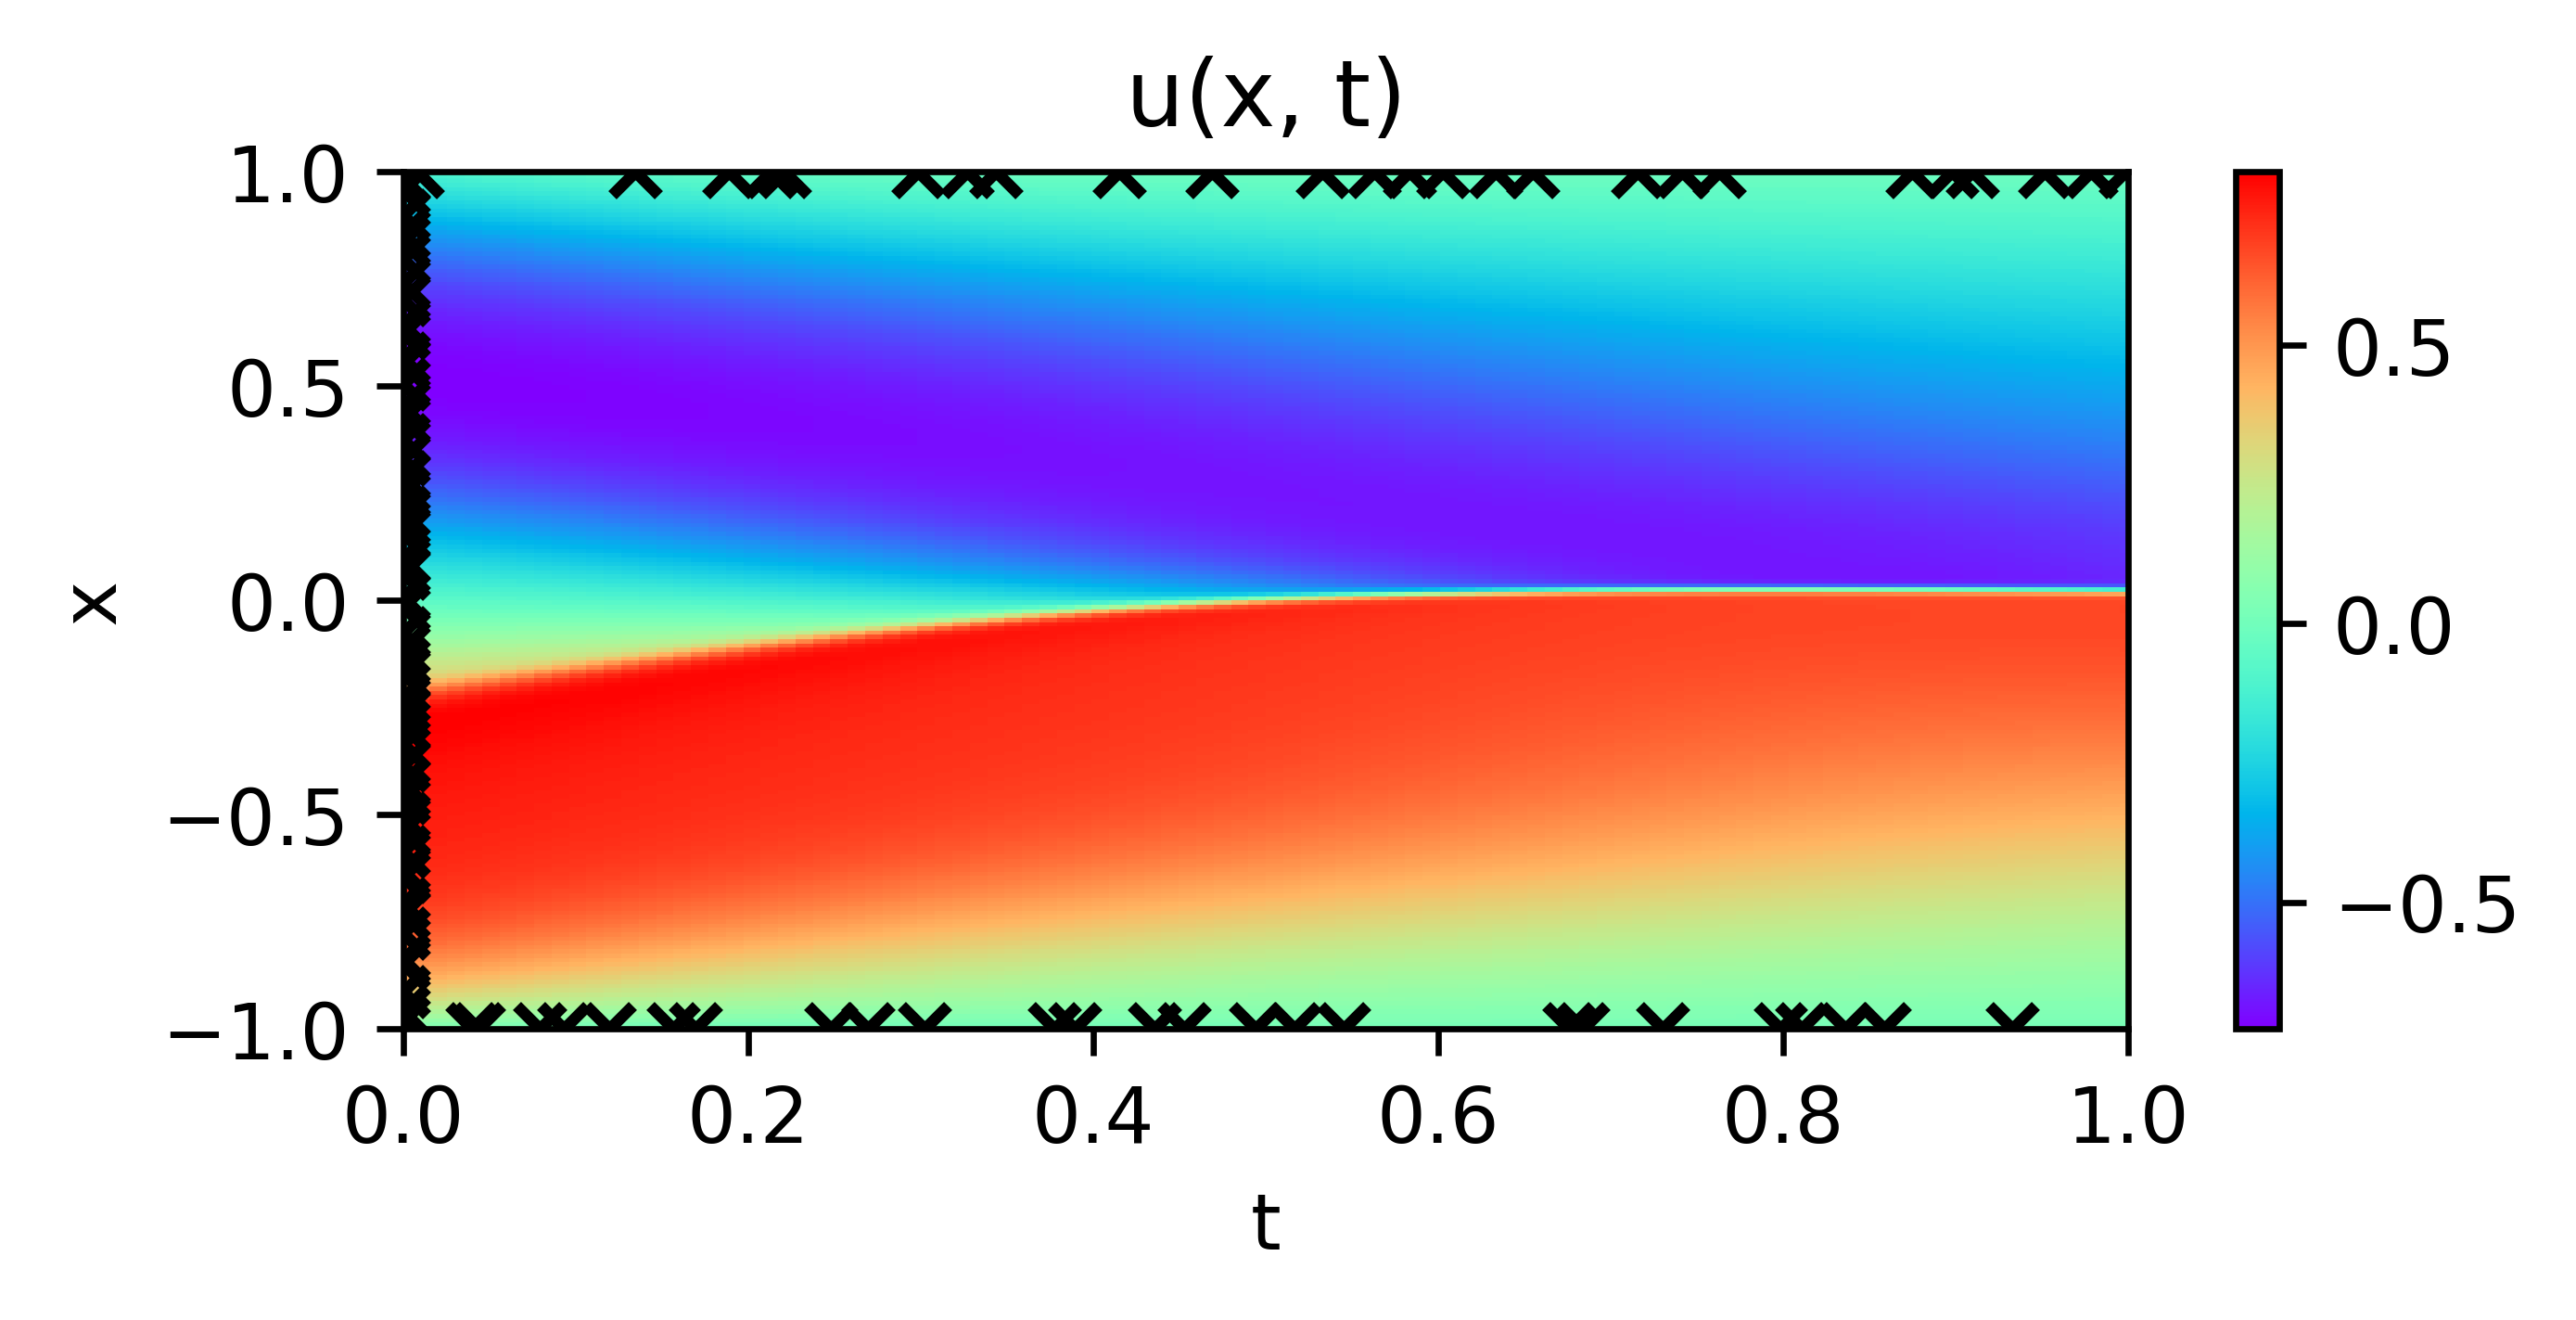

In [ ]:
### plot
# another code is also available for ploting
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=600)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

In [ ]:
# save and copy model to drive

#model.save("b_12x20.h5")

ValueError: Unable to create dataset (name already exists)